# Mechanics of LoRA Fine‑Tuning for **FLUX.2 [klein] Base** (Non‑Distilled)
## What Actually Matters (45‑min, intermediate)

**Audience**: knows LoRA basics. We focus on *where it behaves differently in FLUX*, *how to pick hyperparameters*, and *data/failure diagnosis*.

**Scope**: FLUX.2 [klein] **Base** (non‑distilled, flow matching, 50 steps) — not the distilled Klein models.

---

**Session map (45 min)**
1. Why Klein Base behaves differently (8 min)
2. Where LoRA goes and what it learns (10 min)
3. Hyperparameters that actually move the needle (10 min)
4. Data strategy + failure diagnosis (12 min)
5. Practical recipe + Q&A (5 min)


In [12]:
# Display helper for local SVGs
from pathlib import Path
from IPython.display import SVG, display

ASSETS = Path('assets')

print('Ready')


Ready


---
# 1) Why **Klein Base** behaves differently

Key points (no math derivations):
- **Flow matching** instead of DDPM → training is smoother, fewer hacks for SNR weighting.
- **Non‑distilled** → more capacity to learn new concepts during fine‑tuning.
- **Dual‑stream architecture** → text/image binding happens early; visual detail later.

**Use this to set expectations:** LoRA feels *more stable* on Klein Base, but still overfits fast with small datasets.


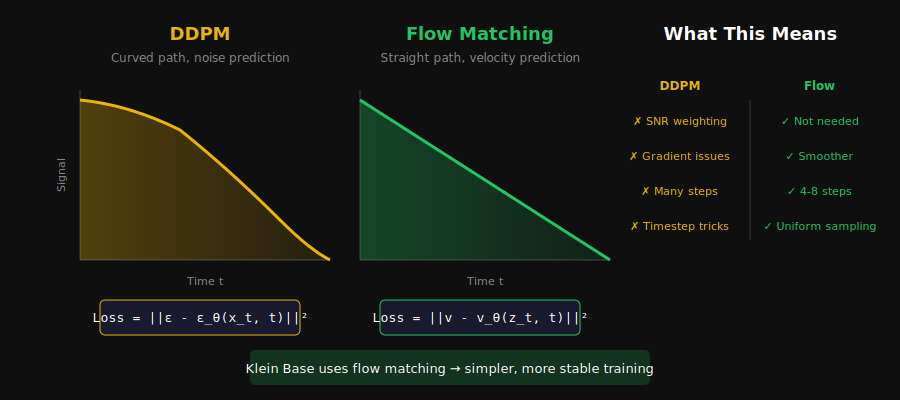

In [13]:
# Flow matching vs DDPM (conceptual)
display(SVG(ASSETS / 'flow_vs_ddpm.svg'))


---
# 2) Where LoRA goes (and why it matters)

Klein has **double‑stream** blocks then **single‑stream** blocks.
This gives you a *clean mental model* for targeting LoRA.

- **Double‑stream (0–4)**: text‑image binding (trigger ↔ concept).
- **Single early (5–10)**: texture, color, low‑level style.
- **Single mid (11–18)**: parts, identity, structure.
- **Single late (19–24)**: composition & layout.

**Practical rule:**
- Start with **attention‑only (QKV/O)** on all blocks.
- Add **MLP** only when concept is complex or detail‑heavy (characters, products).


In [14]:
# Architecture overview
display(SVG(ASSETS / 'klein_architecture.svg'))


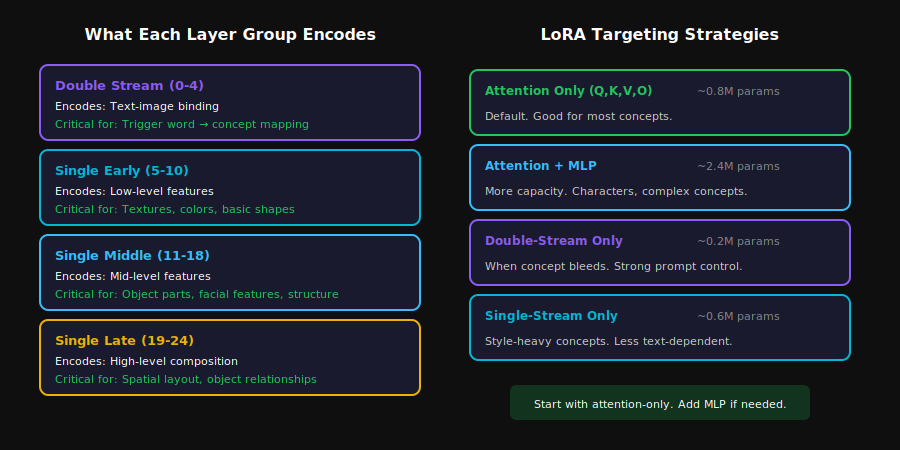

In [15]:
# Layer‑wise intuition + targeting options
display(SVG(ASSETS / 'layer_analysis.svg'))


---
# 3) Hyperparameters that actually matter

We only need 4 knobs for 90% of LoRAs:
- **Rank** (capacity)
- **Alpha** (strength scaling)
- **Learning rate** (speed)
- **Steps** (duration)

**Recommended starting points (Klein Base 4B)**
- **Style**: rank 16, alpha 16, lr 3e‑4, 500–800 steps
- **Character / Face**: rank 32, alpha 32, lr 2e‑4, 800–1200 steps
- **Object / Product**: rank 24, alpha 24, lr 2e‑4, 600–1000 steps
- **I2I Transform**: rank 32, alpha 32, lr 1e‑4, 250–500 steps

**Key insight**: `alpha/rank` ≈ effective strength. Keeping it ≈1.0 is safe.


## 3.1 Rank vs Alpha (what *changes* when you touch them)

**Rank = capacity** (how much detail the LoRA can store).
**Alpha = strength** (how loud that stored change is).

**Practical heuristics**
- Keep **alpha ≈ rank** to start.
- If concept is *weak* → increase **rank** (capacity) before cranking **alpha**.
- If concept is *too strong / bleeds* → reduce **alpha** or steps.

**Talking point:** Two LoRAs with the same `alpha/rank` ratio can behave differently. Higher rank usually *generalizes* better but can overfit faster.


## 3.2 Learning Rate × Steps (the stability window)

**Rule of thumb:**
- Higher LR → fewer steps, faster learning, higher risk of instability.
- Lower LR → more steps, stable but can underfit.

**Start here (Klein Base 4B):**
- LR **1e‑4 to 3e‑4**
- Steps **500–1200**

**Stop training if:**
- Concept appears without trigger
- Prompt changes stop affecting output
- Samples peak then get worse


## 3.2.1 Concept strength vs prompt flexibility (intuition)

A simple mental model you can draw on a whiteboard:
- As steps increase, **concept strength** rises.
- After a point, **prompt flexibility** drops (overfitting).

The goal is to stop at the *peak of concept strength* **before** flexibility collapses.


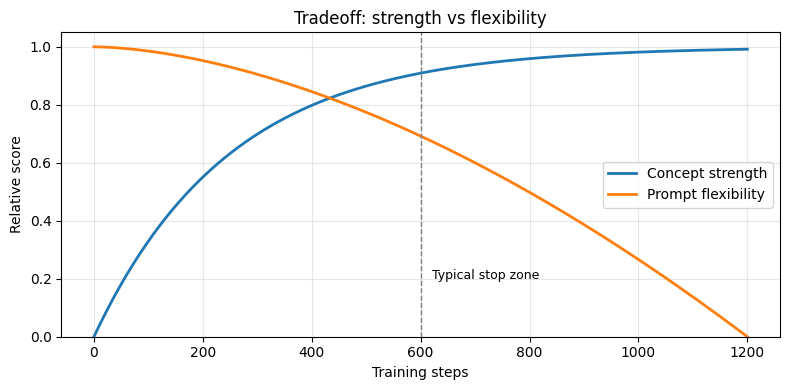

In [16]:
import numpy as np
import matplotlib.pyplot as plt

steps = np.linspace(0, 1200, 200)
strength = 1 - np.exp(-steps/250)
flex = 1 - (steps/1200)**1.7

plt.figure(figsize=(8,4))
plt.plot(steps, strength, label='Concept strength', lw=2)
plt.plot(steps, flex, label='Prompt flexibility', lw=2)
plt.axvline(600, ls='--', color='gray', lw=1)
plt.text(620, 0.2, 'Typical stop zone', fontsize=9)
plt.xlabel('Training steps')
plt.ylabel('Relative score')
plt.title('Tradeoff: strength vs flexibility')
plt.ylim(0,1.05)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## 3.3 Target modules (QKV/O vs +MLP)

**QKV/O only** is the safe default.
- Faster, less risk of identity collapse.

**Add MLP** when you need: 
- Strong identity binding (faces/characters)
- Complex objects with consistent geometry

**If outputs become rigid / samey** → remove MLP or drop rank.


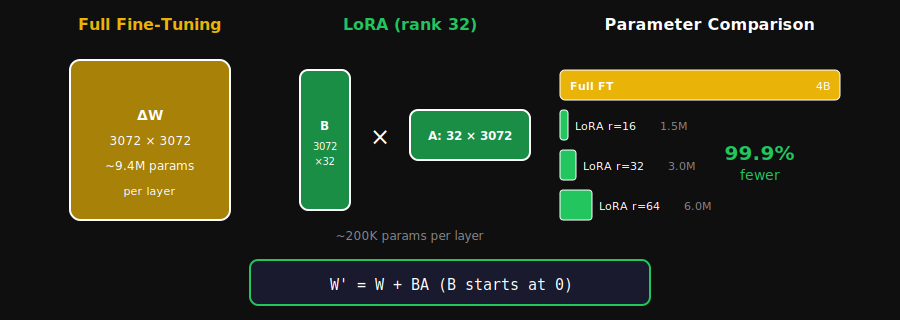

In [17]:
# Parameter‑efficiency reminder (keep light)
display(SVG(ASSETS / 'lora_decomposition.svg'))


---
# 4) Data strategy (quality > quantity)

The model learns **what is consistent** across your images.
That means it will learn your *mistakes* if they are consistent.

**High‑quality checklist**
- Sharp, well‑lit, 1024px+ short side
- Diverse poses / angles / backgrounds
- No near‑duplicates
- Captions include **unique trigger + minimal description**

**Caption pattern**
`[trigger], [subject], [style/lighting], [context]`

**Common failure modes & fixes** (use the guide below).


## 4.5 Holdout evaluation (researcher‑friendly)

Add a **holdout set** that deliberately *breaks your training distribution*:
- New backgrounds
- New poses
- New lighting

**Goal:** confirm the LoRA learned the concept, not the dataset.


## 4.7 Evaluation protocol (research‑friendly)

**Keep this fixed across experiments:**
- **Inference settings**: 50 steps, guidance 4.0 (Klein Base defaults)
- **Seed list**: e.g., [0, 1, 2, 3, 4] 
- **Prompt suite**: trigger‑only, style swap, new scene, no‑trigger leak test
- **Holdout split**: backgrounds/poses not in training

**Why:** makes qualitative results comparable and repeatable.


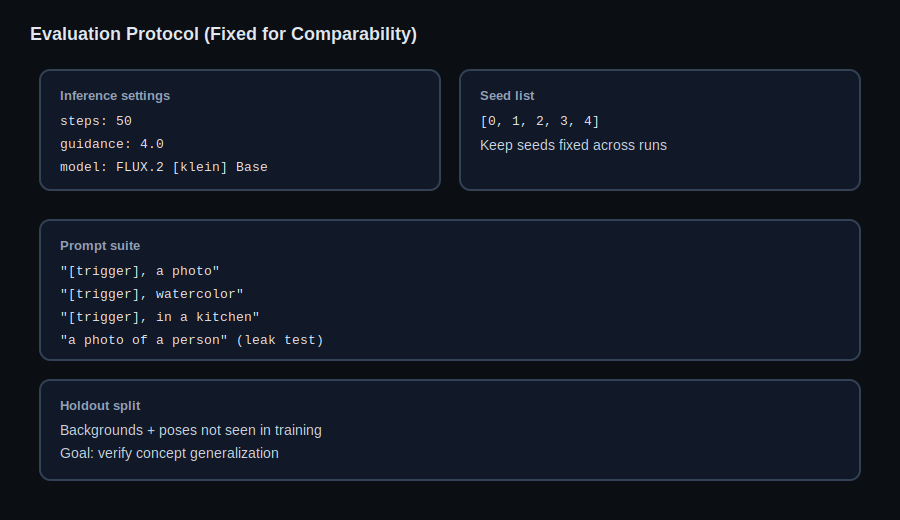

In [18]:
from IPython.display import SVG, display
from pathlib import Path

display(SVG(Path('assets') / 'protocol_eval.svg'))


## 4.6 Minimal quantitative proxies (optional)

If you need numbers (lightweight):
- **Prompt fidelity**: CLIP‑text similarity between prompt and sample
- **Diversity**: LPIPS between different seeds
- **Leakage**: CLIP similarity between *no‑trigger* prompt and samples

These aren’t perfect, but they reveal overfitting early.


## 4.1 Dataset size by task (Klein Base)

- **Style**: 50–200 images
- **Character / face**: 20–60 images (but highly curated)
- **Object / product**: 30–100 images
- **I2I transformation**: 30–100 *pairs*

**Golden rule:** 20 excellent images > 200 mediocre images.


## 4.2 Captioning that actually works

**Goal:** Put the *trigger* in a consistent slot, and describe only what you want learned.

**Good pattern**
```
[trigger], [subject], [style/lighting], [context]
```

**Avoid**
- Empty captions or single words
- Repeating full captions on every image
- Over‑describing backgrounds that you *don’t* want learned


### Example: training pairs (reference → target)

Use 3–4 pairs to show what the model is learning.


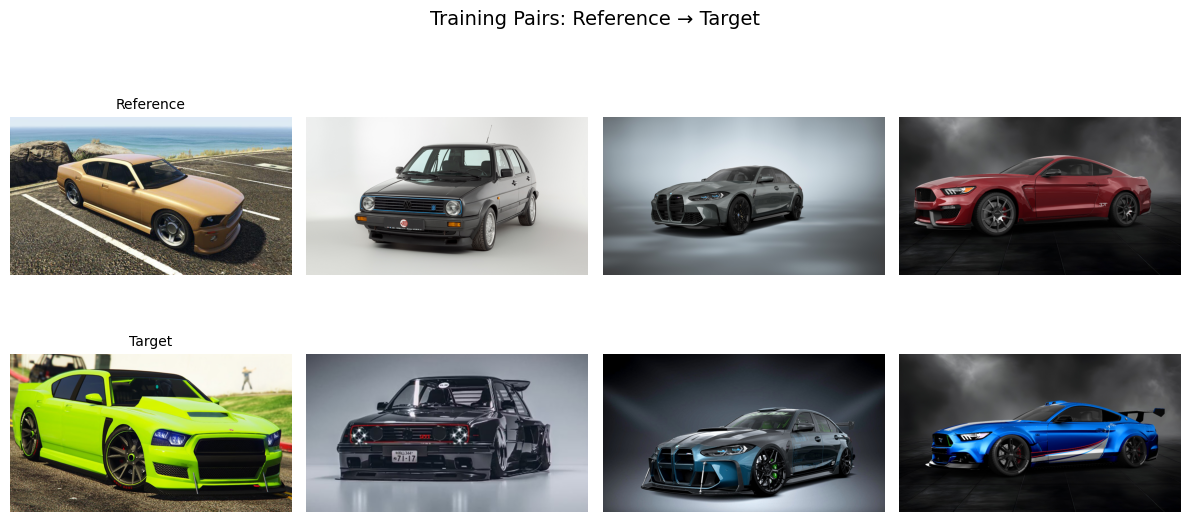

In [19]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

DATA_DIR = Path('training_data')
refs = DATA_DIR / 'pimpmyride_control'
tgts = DATA_DIR / 'pimpmyride'

pairs = ['001', '003', '017', '037']
fig, axes = plt.subplots(2, len(pairs), figsize=(12, 6))
for i, idx in enumerate(pairs):
    ref_path = refs / f'{idx}.png'
    tgt_path = tgts / f'{idx}.png'
    if ref_path.exists():
        axes[0, i].imshow(Image.open(ref_path))
    axes[0, i].axis('off')
    axes[0, i].set_title('Reference' if i == 0 else '', fontsize=10)

    if tgt_path.exists():
        axes[1, i].imshow(Image.open(tgt_path))
    axes[1, i].axis('off')
    axes[1, i].set_title('Target' if i == 0 else '', fontsize=10)

plt.suptitle('Training Pairs: Reference → Target', fontsize=14)
plt.tight_layout()
plt.show()


## 4.3 Data mistakes that cause overfitting

- Near‑duplicates (same pose/angle)
- Consistent background colors
- Reused camera angles
- Watermarks or UI elements

**Symptom:** The LoRA “learns the dataset” instead of the concept.


## 4.4 Quick validation prompt suite (use every time)

Run a small prompt battery every ~100–200 steps:
- **Trigger only**: `"[trigger], a photo"`
- **Trigger + style change**: `"[trigger], watercolor"`
- **Trigger + different scene**: `"[trigger], in a kitchen"`
- **No trigger**: `"a photo of a person"`

**Pass criteria:**
- Trigger changes the subject
- Style prompts still work
- No trigger = no concept leakage


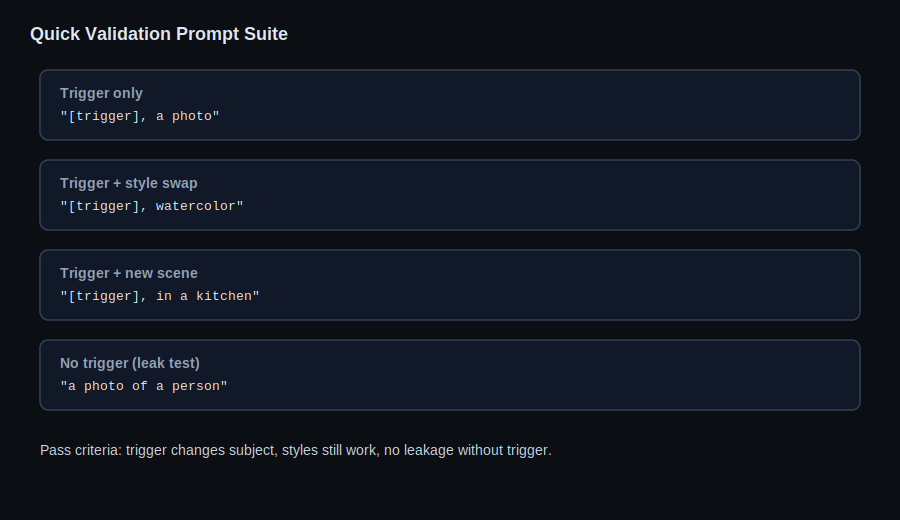

In [20]:
from IPython.display import SVG, display
from pathlib import Path

display(SVG(Path('assets') / 'prompt_suite.svg'))


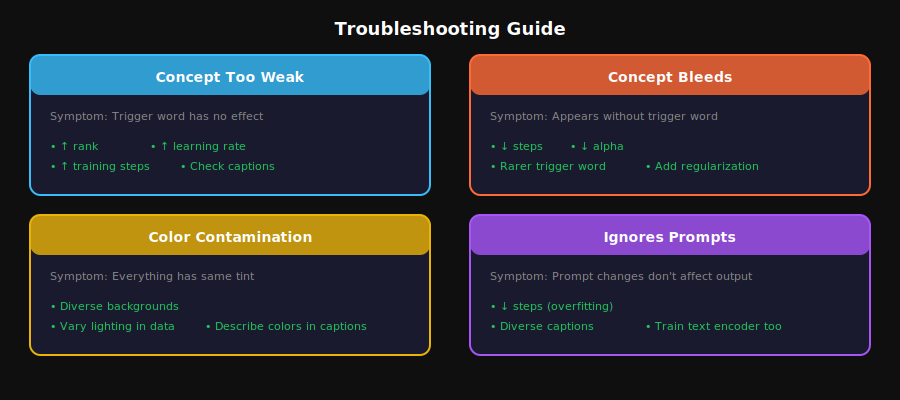

In [21]:
# Failure modes / troubleshooting
display(SVG(ASSETS / 'troubleshooting.svg'))


---
# 5) FLUX‑specific tips (Klein Base)

These are *specific* to FLUX.2 [klein] Base (non‑distilled):
- **Default inference**: 50 steps, guidance 4.0 (base models).
- **Text encoder**: Qwen3 for Klein (different from FLUX.2‑dev).
- **No guidance embedding** in Klein (guidance behaves more like external CFG).

**Takeaway**: Klein Base is the best target for LoRA training. Distilled Klein is for fast inference.


## 5.4 AI Toolkit notes (community signal)

**Why include this:** researchers often ask about tooling + configs.

From community configs / issues, AI Toolkit appears to support a `flux2` arch with:
- `sampler: flowmatch`
- `guidance_scale` around **4**
- `sample_steps` around **25**

**Caveat:** the AI Toolkit README focuses on FLUX.1; Flux2 support is mostly visible via community configs/tutorials.
Use this as a *reference*, not a canonical spec.

Example config snippet (illustrative):
```yaml
model:
  arch: flux2
  quantize: true
  low_vram: true
sample:
  sampler: flowmatch
  guidance_scale: 4
  sample_steps: 25
```


## 5.1 Why Base (non‑distilled) is best for LoRA

Distilled Klein is built for **fast inference** (4 steps).
Klein **Base** preserves capacity and is the right target for training.

**Use distilled only for inference / deployment** — not for LoRA training.


## 5.2 Guidance defaults and expectations

Klein Base defaults to **guidance 4.0** and **50 steps**.
That’s the regime your LoRA should be evaluated in.

**Common mistake:** Training at one guidance, then judging at another.


## 5.3 FLUX text encoder note

Klein uses **Qwen3** text encoder (different from FLUX.2‑dev).
If you train a text‑encoder LoRA, it will be **Qwen3‑specific**.


---
# 6) Practical recipe (one slide)

**If you only remember one recipe:**

- **Model**: FLUX.2 [klein] Base 4B
- **Rank/Alpha**: 16–32, alpha = rank
- **LR**: 1e‑4 to 3e‑4
- **Steps**: 500–1200 (watch for overfit)
- **Targets**: QKV/O attention across all blocks
- **Data**: 20–100 *great* images, unique trigger, diverse contexts

**Stop training if**:
- Concept appears without trigger (overfit)
- Prompt changes stop affecting output
- Validation/sample quality peaks then degrades


## 6.1 Decision tree (fast debugging)

**Problem: Concept too weak**
- ↑ rank 
- ↑ steps
- ↑ LR (small increments)

**Problem: Concept appears without trigger**
- ↓ steps
- ↓ alpha
- Use rarer trigger

**Problem: Style bleeding / color cast**
- Add more background diversity
- Caption colors explicitly

**Problem: Ignores prompt changes**
- Reduce steps
- Increase caption diversity
- Consider text‑encoder LoRA


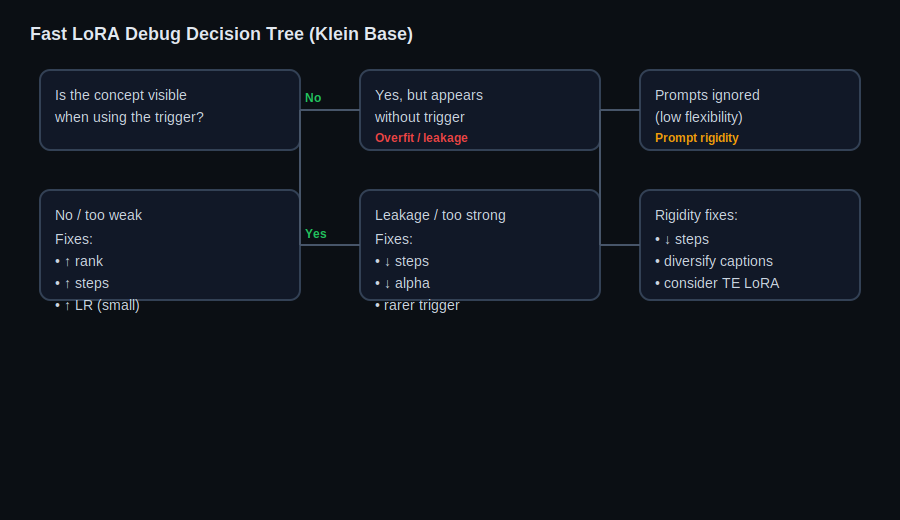

In [22]:
from IPython.display import SVG, display
from pathlib import Path

display(SVG(Path('assets') / 'decision_tree.svg'))


## 6.2 Minimal training loop (conceptual)

Pseudo‑workflow:
1. Curate dataset + captions
2. Choose targets (QKV/O)
3. Train 500–1200 steps
4. Evaluate prompt suite every 100–200 steps
5. Stop when quality peaks

**Key idea:** Sampling during training beats watching loss alone.


---
# Optional appendices (if time)

- **Text encoder LoRA**: only if you need to teach a *new word* or brand name.
- **PEFT alternatives**: DoRA helps text alignment; LoKr when parameter budget is tight.
- **LoRA merging**: works when concepts are orthogonal, fails when triggers overlap.


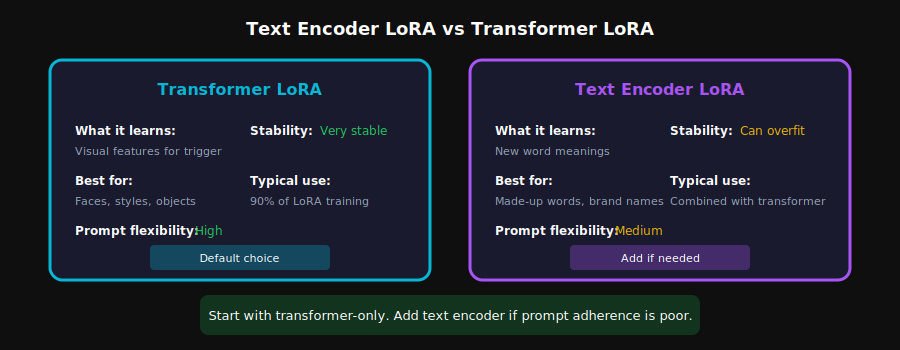

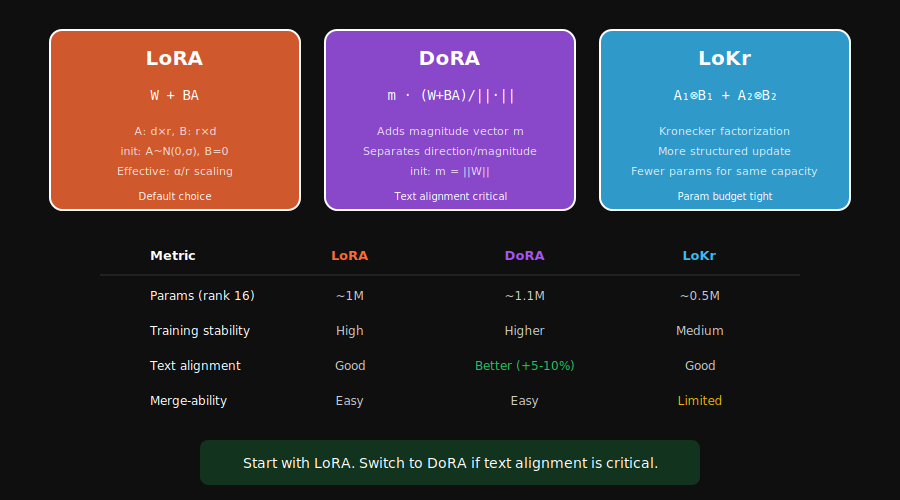

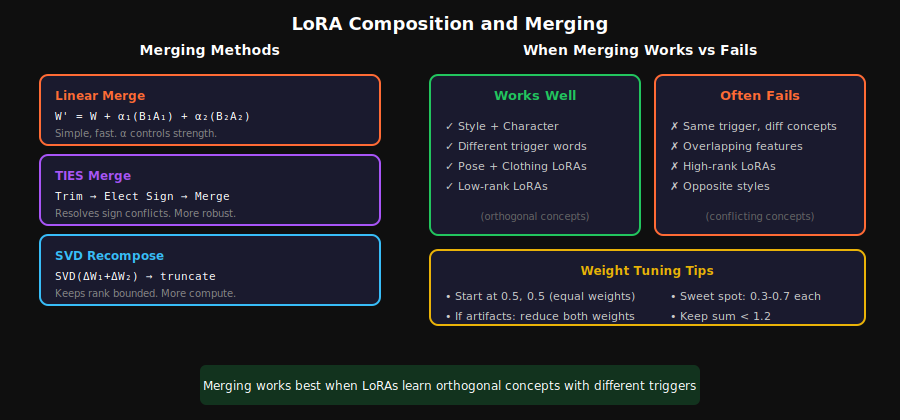

In [24]:
# Optional appendix visuals
display(SVG(ASSETS / 'text_encoder_tuning.svg'))
display(SVG(ASSETS / 'peft_comparison.svg'))
display(SVG(ASSETS / 'lora_merging.svg'))


---
# 8) Closing slide (key takeaways)

1. **Klein Base (non‑distilled) is the training target**.
2. **Where you place LoRA matters** (double‑stream vs single‑stream).
3. **Rank/steps/LR** are your primary levers.
4. **Data quality** is the biggest driver of success.
5. **Validate with prompts, not just loss.**
